In [1]:
import pandas
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, log_loss, mean_squared_error, r2_score, explained_variance_score, make_scorer
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np
from xgboost import plot_importance

import shap
import scipy.stats as st
from scipy.stats import randint, poisson
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
plt.rcParams['font.size'] = 18
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.feature_selection import SelectKBest, f_classif, chi2
import random

In [2]:
df1 = pd.read_csv('data\etalon_jitter_16Mar20_etalon.ccfSum-telemetry.csv')
df2 = pd.read_csv('data\etalon_jitter_18Mar20_etalon.ccfSum-telemetry.csv')
df3 = pd.read_csv('data\etalon_jitter_26Mar20_Cryo_etalon.ccfSum-telemetry.csv')
df4 = pd.read_csv('data\etalon_jitter_26Mar_whitebox_etalon.ccfSum-telemetry.csv')

In [16]:
frames = [df1, df2, df3, df4]
data = np.array(pd.concat(frames))

In [17]:
# jd = np.array((result['JD_UTC']))

#print(df1['JD_UTC'][0])
# print(df2['JD_UTC'][10])
# print(df3['JD_UTC'][10])
# print(df4['JD_UTC'][10])

# print(jd[10], jd[len(df1)+10], jd[len(df1)+len(df2)+10], jd[len(df1)+len(df2)+len(df3)+10])

In [20]:
names_temp = np.array(df1.axes)
names = []
for i in range(len(names_temp[1])):
    names.append(names_temp[1][i])
names = np.array(names)

# Regression - XGBoost

In [6]:
#test = np.array(df4)[:,3:]
X_test = np.array(df4)[:,3:]
y_test = np.array(df4)[:,1]


frames = [df1, df2, df3]
X = np.array(pd.concat(frames))[:,3:]
y = np.array(pd.concat(frames))[:,1]

### Random Search

In [7]:
seed = 42

parameters_RandomSearch = {'eta': st.uniform(), 
                           'num_round': st.randint(1,11),
                           'max_depth': st.randint(1,10)}

clf_xgb = xgb.XGBRegressor(random_state = seed)

n_iter_search = 10

exp_var = make_scorer(explained_variance_score)
r2 = make_scorer(r2_score)



RandomSearch = RandomizedSearchCV(clf_xgb, 
                                  param_distributions=parameters_RandomSearch, 
                                  n_iter=n_iter_search, 
                                  cv=5, 
                                  return_train_score=True,
                                  random_state=seed,
                                  verbose = False,
                                  scoring = exp_var)

In [8]:
RandomSearch.fit(X, y);

RandomSearch_results = pd.DataFrame(RandomSearch.cv_results_)                 
print("Random Search: \tBest parameters: ", RandomSearch.best_params_, f", Best scores: {RandomSearch.best_score_:.5f}")

[16:14:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:14:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:14:55] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bi


[16:14:56] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:14:56] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:14:56] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language b

[16:14:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { num_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Random Search: 	Best parameters:  {'eta': 0.020584494295802447, 'max_depth': 2, 'num_round': 8} , Best scores: -0.30599


In [9]:
model = xgb.XGBRegressor()
model.fit(X, y);
ypred = model.predict(X_test)

In [10]:
explained_variance_score(y_test,ypred)

-0.2116638474457353

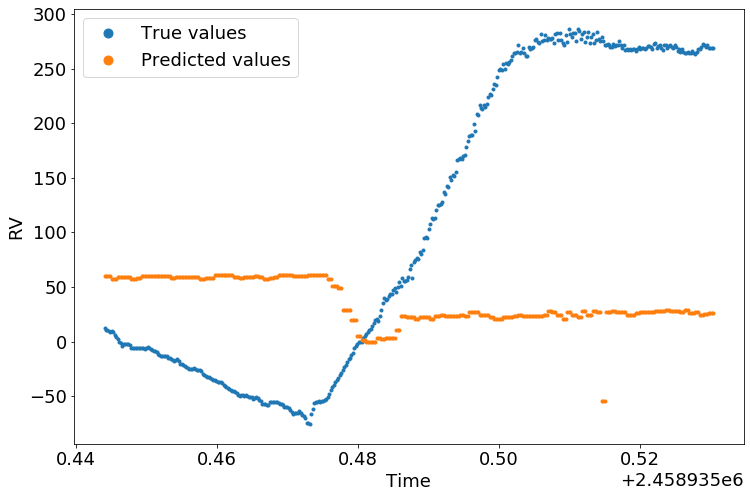

In [11]:
time =  np.array(df4)[:,0]

plt.figure(figsize=(12,8))
plt.plot(time,y_test, '.', color='C0', linewidth = 2, label = 'True values')
plt.plot(time,ypred, '.', color='C1', linewidth = 2, label = 'Predicted values')
plt.xlabel('Time')
plt.ylabel('RV')
plt.legend(markerscale=3);

# NN